# Setup
Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10) 

filenames = 'data/run{}.csv'
datasets = []
for i in range(5):
    data = np.genfromtxt(filenames.format(i), delimiter=', ', comments='#')
    # first line is always header
    data = data[1:]
    datasets.append(data)

# Inspect the data
Currently there are 5 runs, but one had a channel failing and on the last one I changed the electrode pins so we will see if this is useful at all. thus first we take a look at the data from all runs quickly to visually inspect what we have:

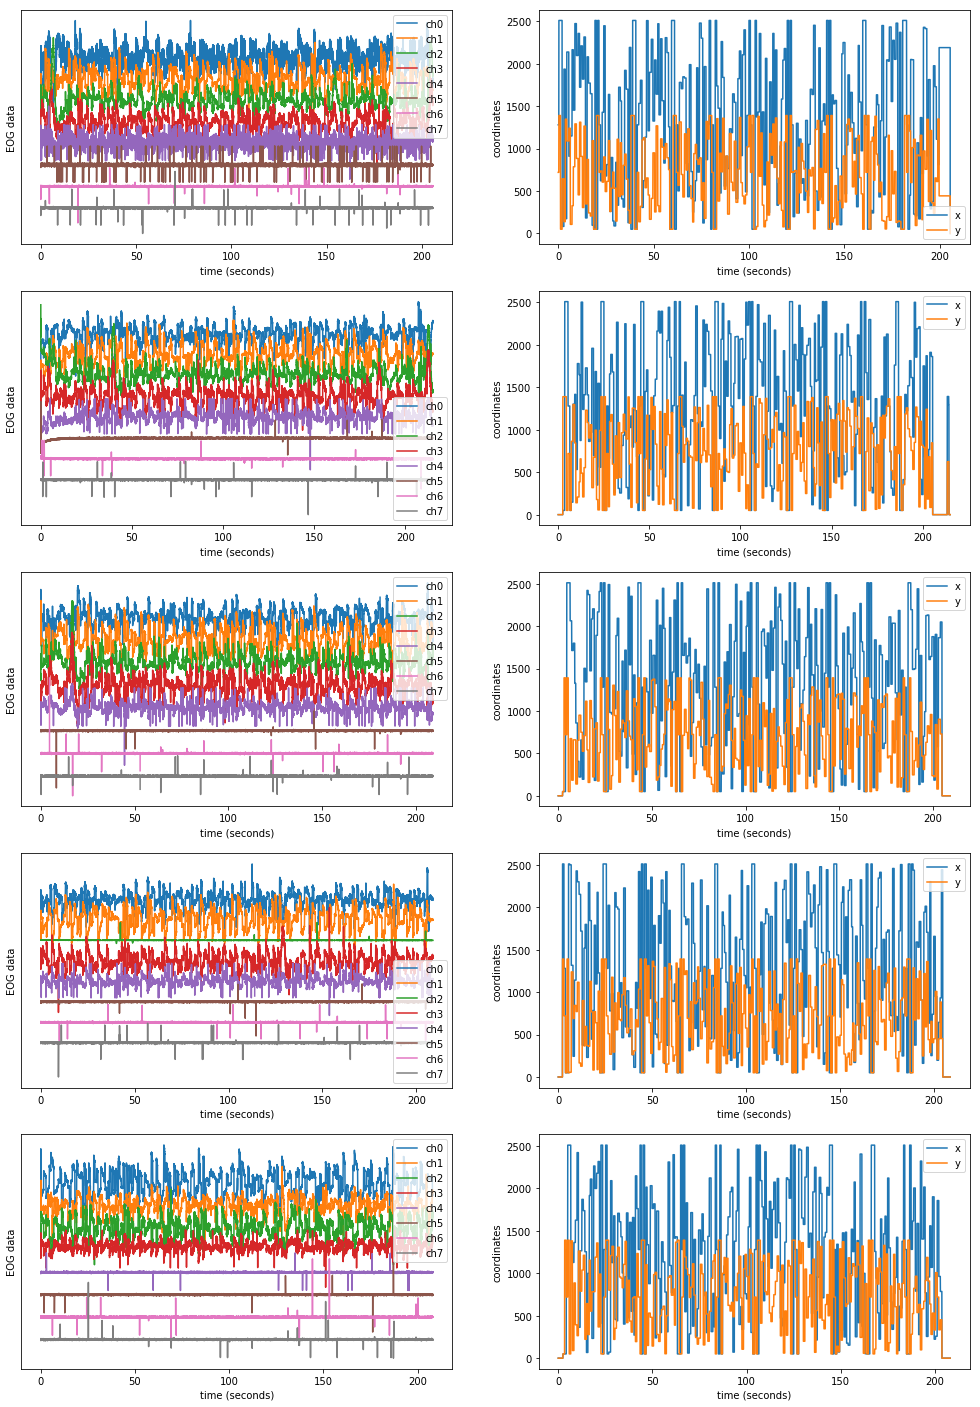

In [2]:
plt.figure(figsize=(17, 25))
for i, data in enumerate(datasets):
    raw_times = data[:, 0].copy()
    eog = data[:, 1:9].copy()
    coords = data[:, 9:].copy()

    times = (raw_times - raw_times[0])
    threshold = 1000
    eog[np.abs(eog) > threshold] = np.nan
    
    plt.subplot(5, 2, 2*i+1)
    offset = 300
    for ch in range(8):
        plt.plot(times, eog[:,ch] - ch*offset, label='ch{}'.format(ch))
    plt.legend()
    plt.xlabel('time (seconds)')
    plt.yticks([], [])
    plt.ylabel('EOG data')
    
    plt.subplot(5, 2, 2*i+2)
    coordnames = ['x', 'y']
    for c in range(2):
        plt.plot(times, coords[:, c], label=coordnames[c])
    plt.legend()
    plt.xlabel('time (seconds)')
    plt.ylabel('coordinates')
    
    

# Channel failure
Clearly the first three runs are good, we have two noisy channels at the start and end and three good channels for the comparisons between the 4 electrodes in the middle.

* In the fourth run, the middle channel failed, which is unfortunate, because this is the data for vertical eye-movement.

* In the fifth channel I moves the electrodes all one pin further on the board. Still there is data missing now.

I will omit runs 4 and 5 for now and only work with runs 1-3. Probably record more data later, when I have a first idea on how the analysis will work in the end.

# More weird behavior
The next day I tried again to record some more data and see, whether the problem still exists. Here there were wird artifacts in the data, where some channels would shift somehow over time and again the middle channel was missing. Here is a short example recording to show the weird behavior:

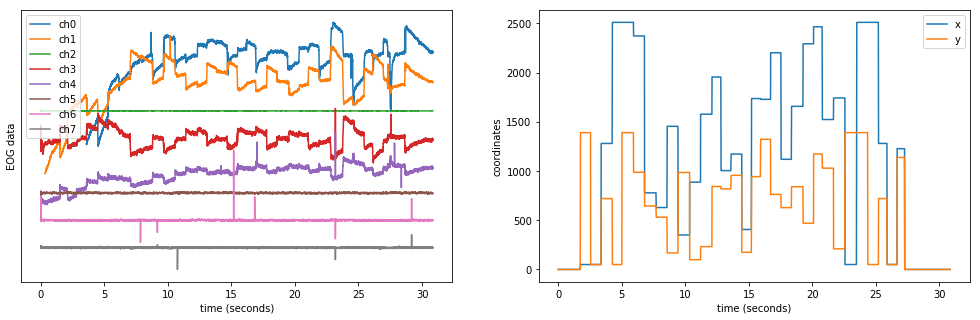

In [3]:
plt.figure(figsize=(17, 5))
weirddata = np.genfromtxt('data/weird_problem.csv', delimiter=', ', comments='#')
weirddata = weirddata[1:, :]
raw_times = weirddata[:, 0].copy()
eog = weirddata[:, 1:9].copy()
coords = weirddata[:, 9:].copy()

times = (raw_times - raw_times[0])
threshold = 1000
eog[np.abs(eog) > threshold] = np.nan

plt.subplot(1, 2, 1)
offset = 300
for ch in range(8):
    plt.plot(times, eog[:,ch] - ch*offset, label='ch{}'.format(ch))
plt.legend()
plt.xlabel('time (seconds)')
plt.yticks([], [])
plt.ylabel('EOG data')

plt.subplot(1, 2, 2)
coordnames = ['x', 'y']
for c in range(2):
    plt.plot(times, coords[:, c], label=coordnames[c])
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('coordinates')
pass

# Explanations?
Since the shift appears only at the beginning of the recording, it could be from moving the head. But still is lasted for almost ten seconds and I always made sure to keep my head still and fixate my eyes on the center of the screen before the recording started.

Anyways, we have again the missing channel in the middle.

# Continuing...
Let's move on with recordings 1-3 and inspect more of the data.

In [4]:
valid_datasets = datasets[:3]

# Point location sampling
Every run has 10 batches of 20 uniformly distributed points and 5 calibration points in the center and the four corners. That makes for a total of 600 + 150 = 750 points for analysis from the first three runs.

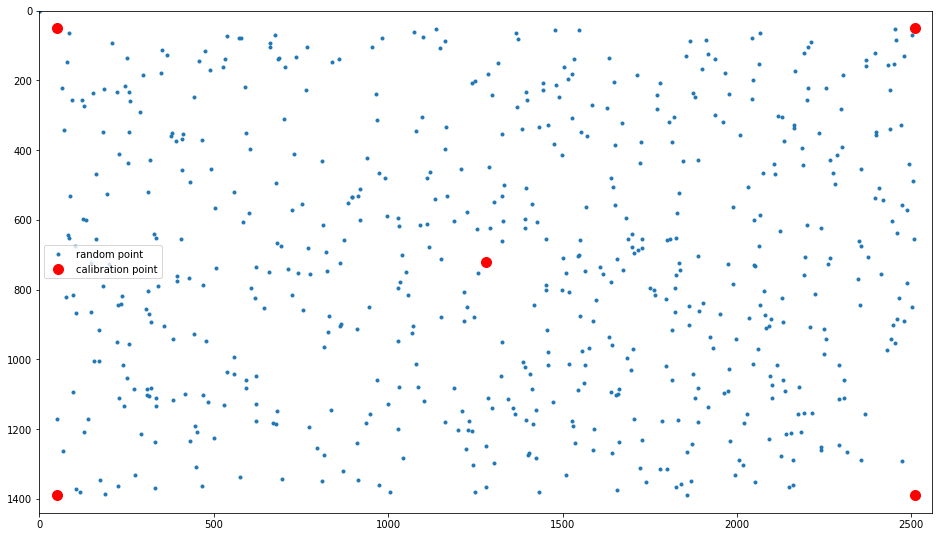

In [5]:
current = (-1,-1)
points = []

for data in valid_datasets:
    for t in range(data.shape[0]):
        point = data[t, (9,10)]
        if any(point != current):
            points.append(point)
            current = point

calibration_points = [
    (50, 50),
    (2510, 50),
    (50, 1390),
    (2510, 1390),
    (1280, 720)
]

plt.plot(*zip(*points), '.', label='random point')
plt.plot(*zip(*calibration_points), '.r', markersize=20, label='calibration point')
plt.xlim(0, 2560)
plt.ylim(1440, 0)
plt.gca().set_aspect('equal', 'box')
plt.legend()
pass

# Point interval sampling
The time between datapoints is sampled from a normal distribution around $\mu = 800ms$ with $\sigma = 100ms$. We can see the distribution of intervals here:

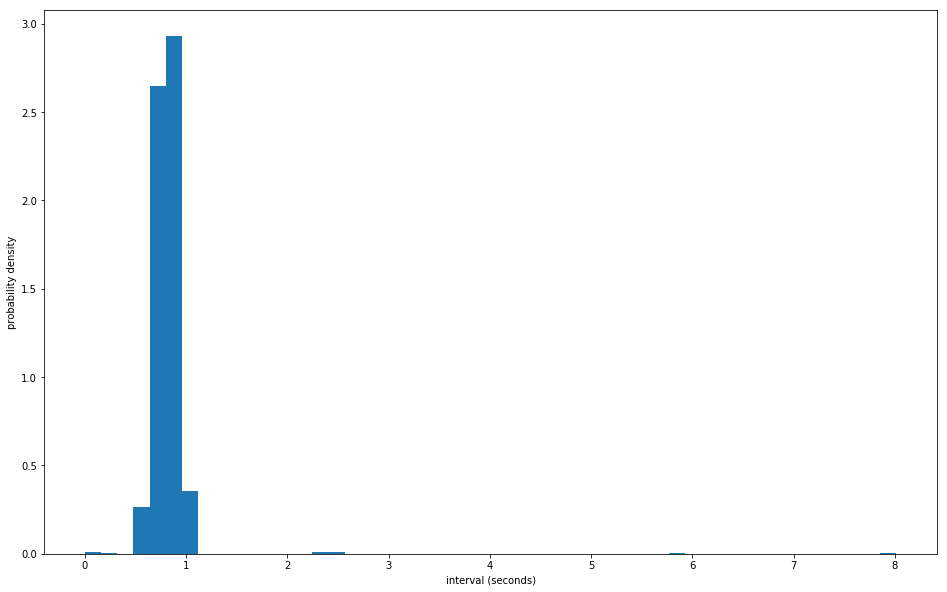

In [6]:
intervals = []
for data in datasets:
    point = data[0, (9, 10)]
    t1 = data[0, 0]
    for t in range(data.shape[0]):
        point = data[t, (9,10)]
        if any(point != current):
            t2 = data[t, 0]
            intervals.append(t2 - t1)
            current = point
            t1 = t2

plt.hist(intervals, bins=50, normed=True)
plt.xlabel('interval (seconds)')
plt.ylabel('probability density')
pass

This plot looks bad because we have outliers from start and end of the recordings. Let's just remove the 3 largest intervals.

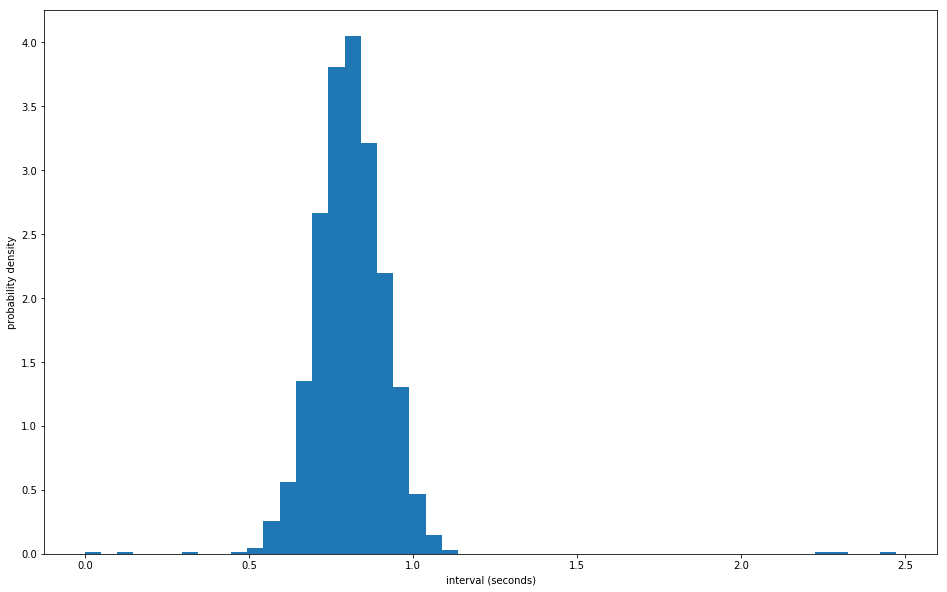

In [7]:
filtered_intervals = list(intervals)

remove_extremes = 3
for _ in range(remove_extremes):
    filtered_intervals.remove(max(filtered_intervals))
    
plt.hist(filtered_intervals, bins=50, normed=True)
plt.xlabel('interval (seconds)')
plt.ylabel('probability density')
pass